# Script to generate a Depth Image using a pre-trained MobileNet U-Net

In [1]:
import os
import glob
import time
from PIL import Image
import numpy as np
import PIL
import random
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.utils as utils
import torchvision.utils as vutils    
import torchvision.models as models
import cv2

from UtilityTest import DepthDataset
from UtilityTest import ToTensor


### Hyperparameters 

In [2]:
data = "C:/Users/hunte/OneDrive/Documents/Projects/Major_Project/Depth_estimation/workspace/test_img"
pretrained_path = "C:/Users/hunte/OneDrive/Documents/Projects/Major_Project/Depth_estimation/workspace/10.pth"

batchSize = 1

### Displaying Images

Index:0	Dimensions: (640, 480)
Index:1	Dimensions: (4032, 1908)
Index:2	Dimensions: (640, 480)
Index:3	Dimensions: (640, 480)
Index:4	Dimensions: (480, 273)


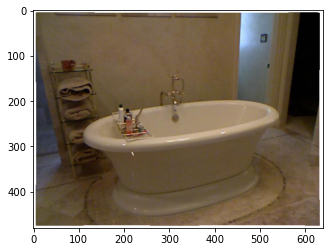

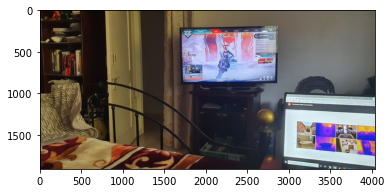

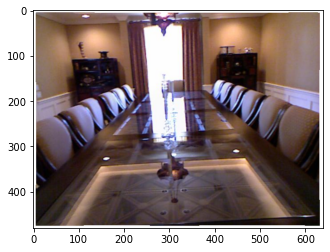

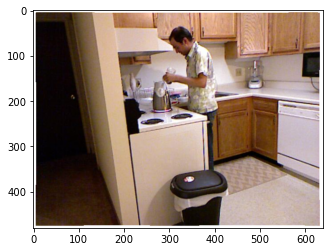

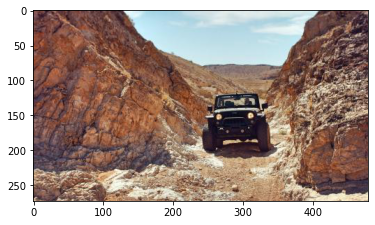

<Figure size 432x288 with 0 Axes>

In [17]:
depth_dataset = DepthDataset(root_dir=data)
fig = plt.figure()
for i in range(len(depth_dataset)):
    sample = depth_dataset[i]
    print("Index:"+ str(i) + "\tDimensions: " + str(sample['image'].size))
    plt.imshow(sample['image'])
    plt.figure()

    if i == len(depth_dataset):
        plt.show()
        break

### Reading the Test Images

In [18]:
start_time = time.time()

depth_dataset = DepthDataset(root_dir=data,transform=transforms.Compose([ToTensor()]))
train_loader=torch.utils.data.DataLoader(depth_dataset, batchSize)
dataiter = iter(train_loader)
images = dataiter.next()

print("\n Time taken to load Images: %s " % (time.time() - start_time))
print("\n Test Dataset Shape: {shape}".format(shape=np.shape(depth_dataset)))


 Time taken to load Images: 0.022003173828125 

 Test Dataset Shape: (5,)


### Importing the Model

In [20]:
from Mobile_model import Model
model = Model().cuda()
model = nn.DataParallel(model)

# Import the Pre-trained Model

model.load_state_dict(torch.load(pretrained_path))
print("\n Loaded MobileNet U-Net Weights successfully\n")

model.eval()


 Loaded MobileNet U-Net Weights successfully



DataParallel(
  (module): Model(
    (encoder): Encoder(
      (original_model): MobileNetV2(
        (features): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): InvertedResidual(
            (conv): Sequential(
              (0): ConvBNReLU(
                (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
                (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (2): ReLU6(inplace=True)
              )
              (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (2): InvertedResidual(
    

### Model Variables (state_dict)

In [21]:
# print("\n\nModel's state_dict:\n\n")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

## Generating Depth Images

In [24]:
start_time = time.time()

for i, sample_batched1  in enumerate (train_loader):

    input_image = torch.autograd.Variable(sample_batched1['image'].cuda())

    GFV = model.module.encoder(input_image)
    out = model(input_image)

    x = out.detach().cpu().numpy()

    # The Model outputs an image of the shape (1,1,240,320)
    # The output depth image is now upscaled to get a 480 x 640 image

    img = x.reshape(240,320)
    scale_percent = 200 # percent of original size
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)

    # Resize the image to scaled dimensions
    depth_image = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    rgb_image = sample_batched1['image'].detach().cpu().numpy().reshape(3,480,640).transpose(1,2,0)

    # Saving the Images

    plt.imsave('C:/Users/hunte/OneDrive/Documents/Projects/Major_Project/Depth_estimation/workspace/generated_img/%d_depth.jpg' %i, depth_image) 
    #plt.imsave('C:/Users/hunte/OneDrive/Documents/Projects/Major_Project/Depth_estimation/workspace/generated_img/%d_depth.jpg' %i, depth_image, cmap='inferno') 

    plt.imsave('C:/Users/hunte/OneDrive/Documents/Projects/Major_Project/Depth_estimation/workspace/generated_img/%d_image.jpg' %i, rgb_image) 


print("\n Time taken to generate Depth Images: %s " % (time.time() - start_time))


 Time taken to generate Depth Images: 0.909820556640625 


#### Saving Results in a ZIP File

In [11]:
# import zipfile

# zf = zipfile.ZipFile("myzipfile.zip", "w")
# for dirname, subdirs, files in os.walk("C:/Users/hunte/OneDrive/Documents/Projects/Major_Project/Depth_estimation/workspace/generated_img"):
#     zf.write(dirname)
#     for filename in files:
#         zf.write(os.path.join(dirname, filename))
# zf.close()